**TL;DR:** Initial full attempt resulted in only ~0.5 accuracy on full sample; clearly something is off. Speculated that this was due to the truncated vocabulary used still being too large, and/or not lemmatising, resulting in an inadequate (noisy and/or lossy) word2vec representation. Haven't finished testing this idea yet.

In [5]:
import keras
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.wrappers.scikit_learn import KerasClassifier
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
from sklearn.model_selection import cross_val_score, StratifiedKFold, train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import tensorflow as tf
import word2vec

# Load & prep data

In [ ]:
tweets = pd.read_csv('data/training.1600000.processed.noemoticon.csv', header=None, encoding='ISO-8859-1')

In [ ]:
tweets.shape

In [ ]:
tweets.head()

In [ ]:
tweets[0].value_counts()

In [ ]:
tweets.rename(columns = { 0: 'positive', 5: 'tweet' }, inplace=True)
tweets = tweets[['positive', 'tweet']]
tweets.loc[:, 'positive'] = (tweets.positive == 4).astype(np.uint8)

## Identify number of terms (size of vocabulary) to consider
using IDF (inverse document frequency) distribution

In [6]:
vectoriser = TfidfVectorizer()
doc_terms = vectoriser.fit_transform(tweets.tweet)

In [7]:
stats.describe(vectoriser.idf_)

DescribeResult(nobs=684358, minmax=(2.250207176415574, 14.59236763164987), mean=14.211100645629408, variance=0.7161283022424955, skewness=-3.981211810930763, kurtosis=22.023923629571634)

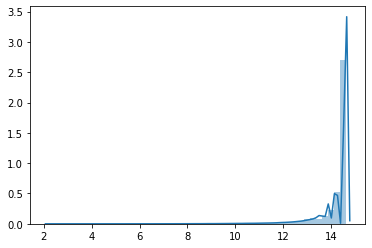

In [8]:
sns.distplot(vectoriser.idf_)

In [9]:
indices_to_words = pd.Series(list(vectoriser.vocabulary_.keys()), index=list(vectoriser.vocabulary_.values()))

In [10]:
word_idxs_invfreq_sorted = np.argsort(vectoriser.idf_)

In [11]:
indices_to_words[word_idxs_invfreq_sorted].iloc[:30]

613861      to
600797     the
433663      my
68527      and
300094      it
675497     you
299013      is
235685     for
293405      in
458032      of
462013      on
402259      me
600330    that
563436      so
269160    have
124252     but
330392    just
658180    with
95144       be
82734       at
452789     not
648494     was
453592     now
607680    this
128986     can
634734      up
255508    good
177229     day
61704      all
466370     out
dtype: object

#### Where do the terms stop making sense?
Finding a threshold at which to exclude terms

In [12]:
indices_to_words[word_idxs_invfreq_sorted].iloc[50000:50050]

95687               beary
571682            squiffy
390977          mamzellef
223551              facit
657158             winder
421653      mollyschambrs
45432              _nathy
383288           luscious
647266              walao
182537           denicesy
421651             mollys
428031           mrscantz
661779               wren
574077             startd
561892              smont
538452      scizzorwizard
204198           ebbsbaby
204321          ebonyeeee
329413            julieem
451393             nolans
576239    stephy_michelle
390851          mameekins
95752             beatccr
217586          esperanto
616901               tope
576253       stephylouise
676373              youur
150959            cleaver
337146          katiekayx
341782               kens
217623          esplanade
24598              5years
223269          fabulista
552565           shrnclrk
483119           pinkpebs
183000              depan
29454               6emqk
652839         whaaaaaaat
209842      

In [13]:
indices_to_words[word_idxs_invfreq_sorted].iloc[200000:200050]

181201             deidra
556980             sittig
682301            zuhiboy
388147         magda_m_78
677226               yule
138447           chandrat
575933       stephenshuai
376474        lollingtons
679376               zajã
13399           30million
181062    defyingdestinyy
111968             bonyok
673193             yeeeuh
124545        butterworth
13397               30mil
394623          marjorie5
557082              siwon
162135           craig563
151464         clioawards
584323       supercricket
181057     defygravity213
102541             bhajji
124552           buttfuck
388101              magan
557065            sivi911
557066          sivinjski
607624            thirdly
673191              yeeet
601576         theatricel
557069      siviwekwatsha
162124            craggsc
584329    supercutsaustin
181073          degadeals
417611         misterslim
162125            cragnet
677220               yuky
181072               dega
2496                 1192
102538      

In [14]:
indices_to_words[word_idxs_invfreq_sorted].iloc[200050:200100]

607611         thirdbase7
402468            meanbot
394633      marjoysaerang
138523         changecamp
102561              bhane
151449       clintonwayne
388086          magali777
117871           bridgers
569512         sphynxeyes
402490           meanieee
376492      lollipopswirl
601586     theauroraprjct
13394                30mi
557085               siwy
124543        buttertoast
417610        misterskull
102547            bhalash
402478    meandmybigmouth
117861      bridgelicious
682273             zucker
593556            tashiam
394628       marjoriemliu
429455              msiou
138518     change_clothes
402471              meand
102554             bhambo
102555         bhamboxset
181039            deftlyd
162099         craftyhope
138487       chanelraquel
138483       chanellybaby
429477         msjaebella
138461       chaneldanise
181120            degreee
388112            magaret
593541          tashboard
569525          spiceflow
593540          tashbg0sh
429476      

200,000 looks like a safe cutoff

## word2vec training

### Tokenise (and reassemble) Tweets to include only 200,000 most frequent terms

This is clearly clunky, but it's the best I can do with Tokenizer's current interface

In [15]:
tokeniser = Tokenizer(num_words=200001)
tokeniser.fit_on_texts(tweets.tweet)
tweets.tweet = tokeniser.sequences_to_texts(tokeniser.texts_to_sequences(tweets.tweet))

In [62]:
tweets.to_csv('data/training.1600000.cleaned.csv', index=False)

### Write vocabulary into file compatible with word2vec input format

In [29]:
vocab_file = 'data/tweet_vocab_200000.txt'

In [21]:
f = open(vocab_file, 'w')
f.write(tweets.tweet.str.cat(sep=' '))
f.close()

### Train using vocabulary file and write results

In [7]:
vocab_vectors_file = 'data/tweet_vocab_200000_vectors.bin'

In [55]:
word2vec.word2vec(vocab_file, vocab_vectors_file, size=100, min_count=2, verbose=True)

Starting training using file data/tweet_vocab_200000.txt
Vocab size: 200001
Words in train file: 21045754
Alpha: 0.000024  Progress: 99.92%  Words/thread/sec: 277.68k  

Why is the vocab size one larger than it should be...?

### Create lists of vectors for Tweets

In [8]:
word2vec_model = word2vec.load(vocab_vectors_file)

In [9]:
def get_vector(t):
    if t in word2vec_model:
        return word2vec_model[t]
    return []

In [10]:
tweets['vectors'] = tweets.tweet.apply(lambda tweet: list(map(lambda t: get_vector(t), tweet.split())))
tweets['vectors'] = tweets.vectors.apply(lambda vecs: np.array([v for v in vecs if len(v) > 0]))

#### Pad list of vectors for each Tweet

In [11]:
padded_vectors = sequence.pad_sequences(tweets.vectors, dtype=np.float64, padding='post')

#### This will free up memory and hopefully keep the kernel from dying (as used on my laptop)?

In [12]:
tweets.drop(columns='vectors', inplace=True)

## Build and train a neural network

### Hyperparameter tuning under time constraints: based on data subsample
I know this isn't kosher, but I have a deadline, and hopefully it works well enough for my present purposes?

#### Select random subsample for "cross-validation"
I tried to sample random indices at one go, then select the indexed observations, but my kernel kept dying. Iterating over smaller chunks then aggregating the results seems to be more manageable.

In [13]:
tuning_train_x_chunks, tuning_train_y_chunks = [], []
increment, iter_n = 200000, 8000
for i in range(8):
    start = i * increment
    tuning_train_idx = np.random.randint(start, start + increment, size=iter_n)
    tuning_train_x_chunks.append(padded_vectors[tuning_train_idx])
    y = tweets.positive.iloc[tuning_train_idx].values
    tuning_train_y_chunks.append(np.reshape(y, (y.shape[0], -1)))
tuning_train_x = np.vstack(tuple(tuning_train_x_chunks))
tuning_train_y = np.vstack(tuple(tuning_train_y_chunks))

In [14]:
del tuning_train_x_chunks, tuning_train_y_chunks

In [15]:
tuning_shuffled_idxs = np.arange(tuning_train_x.shape[0])
np.random.shuffle(tuning_shuffled_idxs)
tuning_train_x = tuning_train_x[tuning_shuffled_idxs]
tuning_train_y = tuning_train_y[tuning_shuffled_idxs]

#### Function definitions

In [16]:
def get_model(lstm_units, lstm_do, lstm_recurr_do, dense_units, dense_activ, dense_do, opt):
    #strategy = tf.distribute.MirroredStrategy()
    model = Sequential()
    model.add(LSTM(lstm_units, return_sequences=False, dropout=lstm_do, recurrent_dropout=lstm_recurr_do))
    model.add(Dense(dense_units, activation=dense_activ))
    model.add(Dropout(dense_do))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [17]:
def partition_indices(i, k, index):
    if i < 1 or i > k:
        raise ValueError
    step, n = 1.0 / k, len(index)
    lb, ub = round((i-1) * step * n), round(i * step * n)
    include = list(range(lb))
    include.extend(range(ub, n)) 
    exclude = list(range(lb, ub))
    return index[exclude], index[include]

In [19]:
## Not really k-fold CV, since the model isn't reinstantiated (i.e. weights are carried over from previous
## fold trainings), but c.f. time constraints
# def k_fold_cv(x, y, k, model, cv_verbose=False, **kwargs):
#     accuracy = np.zeros(k)
#     stdevs = np.zeros(k)
#     for i in range(1, k+1):
#         if cv_verbose:
#             print('fold ', i)
#         exclude, include = partition_indices(i, k, np.arange(x.shape[0]))
#         x_fit = x[include]
#         model.fit(x_fit, y[include], **kwargs)
#         exclude_len = len(x[exclude])
#         predictions = np.round(model.predict(x[exclude]))
#         corrects = (predictions == y[exclude]).astype(int)
#         accuracy[i-1] = corrects.mean()
#         stdevs[i-1] = corrects.std()
#     return accuracy, stdevs

In [18]:
def k_fold_cv_iter(x, y, i, k, model, cv_verbose=False, **kwargs):
    exclude, include = partition_indices(i, k, np.arange(x.shape[0]))
    x_fit = x[include]
    model.fit(x_fit, y[include], **kwargs)
    exclude_len = len(x[exclude])
    predictions = np.round(model.predict(x[exclude]))
    return (predictions == y[exclude]).astype(int).mean()

#### First pass (well, after a few undocumented trials)

In [19]:
accuracies = np.zeros(5)
for i in range(1, 6):
    print('fold ', i)
    accuracies[i-1] = k_fold_cv_iter(tuning_train_x, tuning_train_y, i, 5,
                                     get_model(128, 0.1, 0.1, 32, 'relu', 0.5, 'RMSprop'), epochs=3, batch_size=1600)

fold  1
Train on 51200 samples
Epoch 1/3
51200/51200 [==============================] - 60s 1ms/sample - loss: 5.9437e-08 - accuracy: 0.4938
Epoch 2/3
51200/51200 [==============================] - 57s 1ms/sample - loss: 5.9437e-08 - accuracy: 0.4946
Epoch 3/3
51200/51200 [==============================] - 57s 1ms/sample - loss: 5.9437e-08 - accuracy: 0.4937
fold  2
Train on 51200 samples
Epoch 1/3
51200/51200 [==============================] - 60s 1ms/sample - loss: 5.9621e-08 - accuracy: 0.4947
Epoch 2/3
51200/51200 [==============================] - 56s 1ms/sample - loss: 5.9621e-08 - accuracy: 0.4967
Epoch 3/3
51200/51200 [==============================] - 57s 1ms/sample - loss: 5.9621e-08 - accuracy: 0.4928
fold  3
Train on 51200 samples
Epoch 1/3
51200/51200 [==============================] - 61s 1ms/sample - loss: 5.9719e-08 - accuracy: 0.5048
Epoch 2/3
51200/51200 [==============================] - 57s 1ms/sample - loss: 5.9719e-08 - accuracy: 0.5024
Epoch 3/3
51200/51200 [====

In [21]:
accuracies

array([0.50976562, 0.49148437, 0.51351563, 0.5146875 , 0.5190625 ])

In [20]:
accuracies = np.zeros(5)
for i in range(1, 6):
    print('fold ', i)
    accuracies[i-1] = k_fold_cv_iter(tuning_train_x, tuning_train_y, i, 5,
                                     get_model(128, 0.1, 0.1, 64, 'relu', 0.5, 'RMSprop'), epochs=3, batch_size=1600)

fold  1
Train on 51200 samples
Epoch 1/3
51200/51200 [==============================] - 74s 1ms/sample - loss: 5.9535e-08 - accuracy: 0.5137
Epoch 2/3
51200/51200 [==============================] - 61s 1ms/sample - loss: 5.9535e-08 - accuracy: 0.5108
Epoch 3/3
51200/51200 [==============================] - 59s 1ms/sample - loss: 5.9535e-08 - accuracy: 0.5116
fold  2
Train on 51200 samples
Epoch 1/3
51200/51200 [==============================] - 61s 1ms/sample - loss: 5.9626e-08 - accuracy: 0.5096
Epoch 2/3
51200/51200 [==============================] - 58s 1ms/sample - loss: 5.9626e-08 - accuracy: 0.5101
Epoch 3/3
51200/51200 [==============================] - 58s 1ms/sample - loss: 5.9626e-08 - accuracy: 0.5105
fold  3
Train on 51200 samples
Epoch 1/3
51200/51200 [==============================] - 63s 1ms/sample - loss: 5.9728e-08 - accuracy: 0.5025
Epoch 2/3
51200/51200 [==============================] - 57s 1ms/sample - loss: 5.9728e-08 - accuracy: 0.5000
Epoch 3/3
51200/51200 [====

### Checkpoint 13/6/2020: Maybe that subsampling idea was dumb? I've spent much of my time trying to get the kernel not to die, and gotten not much farther from where I started. 

## UNDER CONSTRUCTION

In [21]:
accuracies

array([0.53523438, 0.50351563, 0.50929687, 0.52984375, 0.45015625])

In [ ]:
accuracies = np.zeros(5)
for i in range(1, 6):
    print('fold ', i)
    accuracies[i-1] = k_fold_cv_iter(tuning_train_x, tuning_train_y, i, 5,
                                     get_model(128, 0.1, 0.1, 32, 'relu', 0.2, 'RMSprop'),
                                     epochs=3, batch_size=1600, workers=8, use_multiprocessing=True)

fold  1
Train on 51200 samples
Epoch 1/3
51200/51200 [==============================] - 66s 1ms/sample - loss: 5.9535e-08 - accuracy: 0.5163
Epoch 2/3
51200/51200 [==============================] - 59s 1ms/sample - loss: 5.9535e-08 - accuracy: 0.5185
Epoch 3/3
51200/51200 [==============================] - 58s 1ms/sample - loss: 5.9535e-08 - accuracy: 0.5183
fold  2
Train on 51200 samples
Epoch 1/3
51200/51200 [==============================] - 63s 1ms/sample - loss: 5.9626e-08 - accuracy: 0.4826
Epoch 2/3
51200/51200 [==============================] - 57s 1ms/sample - loss: 5.9626e-08 - accuracy: 0.4824
Epoch 3/3
51200/51200 [==============================] - 57s 1ms/sample - loss: 5.9626e-08 - accuracy: 0.4837
fold  3
Train on 51200 samples
Epoch 1/3
51200/51200 [==============================] - 64s 1ms/sample - loss: 5.9728e-08 - accuracy: 0.4907
Epoch 2/3
51200/51200 [==============================] - 59s 1ms/sample - loss: 5.9728e-08 - accuracy: 0.4903
Epoch 3/3
51200/51200 [====

In [ ]:
accuracies

#### LSTM (64, 0.1, 0.1), dense (64, 0.5)

adadelta: 0.4037, 0.4049, 0.4066, 0.35

RMSprop: 0.4469, 0.4444, 0.4479, 0.34

#### LSTM (128, 0.1), dense (32, 0.5)

RMSprop: 0.4952, 0.5015, 0.4979, 0.46